## Predicting who would survive on the Titanic using machine learning 

## 1. Problem Definition
> Is it possible to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## 2. Data
>Data taken from the Kaggle Titanic competition. The data has been broken into a training and testing CSV. Data includes information such as the passenger's gender and social class. The final submission will just be a DataFrame that contains the passenger's ID and predicted survival status.

* https://www.kaggle.com/competitions/titanic/data

## 3. Evaluation
>My goal for this project is build a model with at least 90% accuracy.

## 4. Features 
>Below is a data dictionary explaining all the different data points

|Variable| Definition| Key|
|:-------|:----------|:---|
|survival|Survival|0 = No, 1 = Yes|
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex|
|Age|Age in years|
|sibsp|# of siblings |# of spouses aboard the Titanic|
|parch|# of parents |# of children aboard the Titanic|
|ticket|Ticket number|
|fare|Passenger fare|
|cabin|Cabin number|
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|

## 5. Initial Predictions
>Without first running the model, my first prediction is that there will be a high correlation between sex, age, ticket class and survival. I believe children, women, and the wealthy were more likely to survive based on preconception of "women and children first" having been followed when evacuating the ship. Lets see how that prediction stacks up!

## Imports 

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

## Data exploration

In [3]:
train = pd.read_csv("./data/train.csv", index_col=0)
test = pd.read_csv("./data/test.csv", index_col=0)
example_submission = pd.read_csv("./data/gender_submission.csv", index_col=0)

train.shape, test.shape, example_submission.shape

((891, 11), (418, 10), (418, 1))

In [4]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
example_submission.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


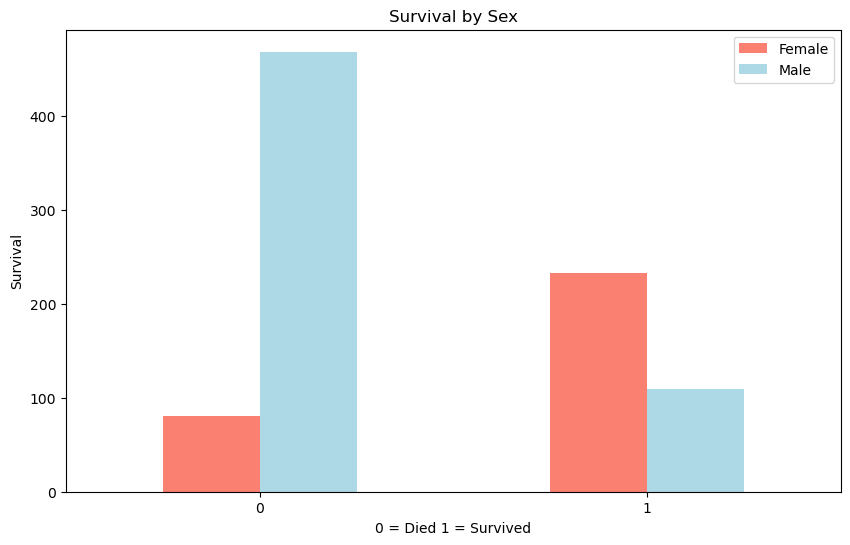

In [7]:
# Comparing survival rate to initial predictions of age, sex, and ticket class
pd.crosstab(train["Survived"], train["Sex"]).plot(kind="bar",
                                                  figsize = (10, 6),
                                                  color=["salmon", "lightblue"])
plt.title("Survival by Sex")
plt.xlabel("0 = Died 1 = Survived")
plt.ylabel("Survival")
plt.legend(["Female", "Male"])
plt.xticks(rotation=0);



In [8]:
test.dtypes

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [9]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [10]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [11]:
train.shape

(891, 11)

## Filling data and converting all data to integers

In [12]:
def fill_unknown_cells(df):
    """
    Fills unknown cells with "Unknown" and then creates an "is missing" category which states
    if that column had an unknown value.
    """
    for label, content in df.items():
        if pd.isnull(content).sum():
            #Add a binary col which tells us if data was missing or not
            df[label+" is missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes + 1

In [13]:
#Create a temporary dataset to transform and test
train_temp = train.copy()

train_temp.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
fill_unknown_cells(train_temp)
train_temp.isna().sum()

Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                  0
Embarked               0
Age is missing         0
Cabin is missing       0
Embarked is missing    0
dtype: int64

In [15]:
train_temp.dtypes

Survived                 int64
Pclass                   int64
Name                    object
Sex                     object
Age                       int8
SibSp                    int64
Parch                    int64
Ticket                  object
Fare                   float64
Cabin                    int16
Embarked                  int8
Age is missing            bool
Cabin is missing          bool
Embarked is missing       bool
dtype: object

In [16]:
#function for converting data
def convert_col_to_num(df):
    """
    Converts columns in a dataframe to numbers for a ML model to understand
    """
    categorical_columns = []
    for label, content in df.items():
        if pd.api.types.is_object_dtype(content) and label not in categorical_columns:
            categorical_columns.append(label)
    
    # Create a copy of the DataFrame
    encoded_df = df.copy()

    # Apply label encoding to object columns
    label_encoder = LabelEncoder()
    
    for column in categorical_columns:
        encoded_df[column] = label_encoder.fit_transform(encoded_df[column].astype(str))
    
    return encoded_df

In [17]:
train_temp = convert_col_to_num(train_temp)
train_temp.dtypes

Survived                 int64
Pclass                   int64
Name                     int64
Sex                      int64
Age                       int8
SibSp                    int64
Parch                    int64
Ticket                   int64
Fare                   float64
Cabin                    int16
Embarked                  int8
Age is missing            bool
Cabin is missing          bool
Embarked is missing       bool
dtype: object

## Training a model

In [18]:
models = {
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}

def fit_and_score(models, df):
    np.random.seed(42)
    model_scores = {}
    
    X = df.drop("Survived", axis=1)
    y = df["Survived"]
    
    for name, model in models.items():
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=kf)
        model_scores[name] = np.mean(scores)
    return model_scores

In [19]:
fit_and_score(models, train_temp)

/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

{'LinearSVC': 0.600477057309648,
 'KNN': 0.6643839055928693,
 'Random Forest': 0.8249325214989642}

It looks like Random Forest has the best baseline predictions! Now I will hypertune it

## Hypertuning with GridSearchCV

In [22]:
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}

gs_rf = GridSearchCV(RandomForestClassifier(),
                     param_grid = param_grid,
                     cv=5,
                     verbose=True)
X = train_temp.drop("Survived", axis=1)
y = train_temp["Survived"]

gs_rf.fit(X, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             verbose=True)

In [23]:
gs_rf.best_params_

{'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 6,
 'n_estimators': 150}

In [24]:
gs_rf.best_score_

0.8058502291130502

## Running the hypertuned model on the test data

In [25]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [26]:
test_temp = test.copy()
test_temp.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [27]:
fill_unknown_cells(test_temp)
test_temp.isna().sum()

Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin               0
Embarked            0
Age is missing      0
Fare is missing     0
Cabin is missing    0
dtype: int64

In [28]:
test_temp = convert_col_to_num(test_temp)
test_temp.dtypes

Pclass              int64
Name                int64
Sex                 int64
Age                  int8
SibSp               int64
Parch               int64
Ticket              int64
Fare                int16
Cabin                int8
Embarked            int64
Age is missing       bool
Fare is missing      bool
Cabin is missing     bool
dtype: object

In [31]:
models['Random Forest']

RandomForestClassifier()

In [32]:
model = RandomForestClassifier()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)

print(f"Average Score: {np.mean(scores)}")
model.fit(X, y)

Average Score: 0.8327851358985626


RandomForestClassifier()

In [33]:
test_temp.columns

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Age is missing', 'Fare is missing',
       'Cabin is missing'],
      dtype='object')

In [34]:
train_temp.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Age is missing', 'Cabin is missing',
       'Embarked is missing'],
      dtype='object')

In [35]:
train_temp["Fare is missing"] = False
test_temp["Embarked is missing"] = False

## Retraining model with missing columns filled between test and train

In [37]:
X = train_temp.drop("Survived", axis=1)
y = train_temp["Survived"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)

print(f"Average Score: {np.mean(scores)}")
model.fit(X, y)

Average Score: 0.8237963718536188


RandomForestClassifier()

In [38]:
# Get columns in same order in train and test
train_columns = X.columns.tolist()
test_temp = test_temp[train_columns]

predictions = model.predict(test_temp)
predictions[:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0])

In [63]:
predictions.shape

(418,)

In [39]:
predictions

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,

## Exporting initial predictions to CSV

In [40]:
test_temp.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age is missing,Cabin is missing,Embarked is missing,Fare is missing
PassengerId,,,,,,,,,,,,,,
892,3,206,1,45,0,0,152,25,0,1,False,True,False,False
893,3,403,0,61,1,0,221,6,0,2,False,True,False,False
894,2,269,1,75,0,0,73,42,0,1,False,True,False,False
895,3,408,1,35,0,0,147,35,0,2,False,True,False,False
896,3,178,0,28,1,1,138,47,0,2,False,True,False,False


In [41]:
passenger_ids = test_temp.index

df = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})

df.to_csv('predictions.csv', index=False)

## Evaluating predicitons of initial model

In [43]:
feature_dict = dict(zip(test_temp.columns, list(model.feature_importances_)))
feature_dict

{'Pclass': 0.052537729606636885,
 'Name': 0.1368970654267843,
 'Sex': 0.22415511940131083,
 'Age': 0.1094888080918423,
 'SibSp': 0.03264179243427343,
 'Parch': 0.0315162450394787,
 'Ticket': 0.1654743353581262,
 'Fare': 0.13028916944950453,
 'Cabin': 0.06453167042838809,
 'Embarked': 0.023218353277883158,
 'Age is missing': 0.010424598907922421,
 'Cabin is missing': 0.01872457978074151,
 'Embarked is missing': 0.00010053279710771739,
 'Fare is missing': 0.0}

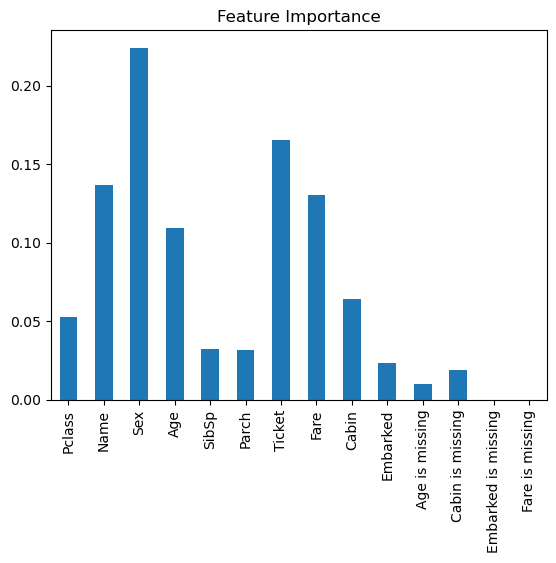

In [45]:
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title="Feature Importance", legend=False);

>As can be seen in the abvoe graph, my predicitons about sex and class being highly correlated with survival holds water. It seems that the ticket number is also very important to the model. Perhaps the ticket holders which had cabins closer to the top of the ship had a much better chance of survival.

## Measuring cross validated metrics

In [48]:
rf_precision = cross_val_score(model,
                         X,
                         y, 
                         cv=5,
                         scoring="precision")
np.mean(rf_precision)

0.8057888255513733

In [49]:
rf_acc = cross_val_score(model,
                         X,
                         y, 
                         cv=5,
                         scoring="accuracy")
np.mean(rf_acc)

0.8294269035214363

In [52]:
rf_recall = cross_val_score(model,
                         X,
                         y, 
                         cv=5,
                         scoring="recall")
np.mean(rf_recall)

0.7133844842284741

In [53]:
rf_f1 = cross_val_score(model,
                         X,
                         y, 
                         cv=5,
                         scoring="f1")
np.mean(rf_f1)

0.7555113263441717

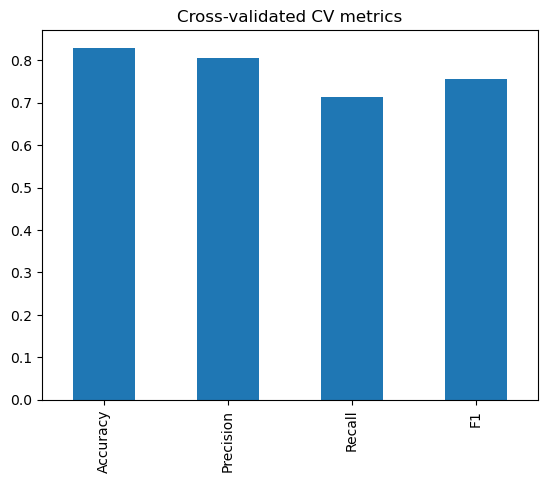

In [62]:
#Visualize the cross-validated metrics
rf_metrics = pd.DataFrame({"Accuracy": np.mean(rf_acc),
                           "Precision": np.mean(rf_precision),
                           "Recall": np.mean(rf_recall),
                           "F1": np.mean(rf_f1)}, index=[0])

rf_metrics.T.plot.bar(title="Cross-validated CV metrics",
                      legend=False);

>As can be seen from the ~10% difference between accuracy and recall, the model has a problem with creating false negatives. Now lets see how the model compares to one that predicts every passenger died.

In [71]:
everyone_died = np.zeros((891, 1))
everyone_died.shape

y_true = train_temp['Survived']  # Assuming 'Survived' column exists in the test set

accuracy = accuracy_score(y_true, everyone_died)
print("Accuracy:", accuracy)

Accuracy: 0.6161616161616161


>So, a guess that everyone died would be about 61.6% accurate, so my model is outperforming that by about 20%. I want to do 

## Next steps
>So, this model is good but not great. My next steps will be excluding columns to see if that improves the learning of the model as well as trying a new model

>First, lets try out how a Gradient Boosting classifier does in comparison to the other models

In [74]:
models = {
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosted": GradientBoostingClassifier()
}

fit_and_score(models, train_temp)

/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/michaelmiller/anaconda3/envs/titanic/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

{'LinearSVC': 0.600477057309648,
 'KNN': 0.6643839055928693,
 'Random Forest': 0.8327976900382902,
 'Gradient Boosted': 0.8204193082669011}

In [75]:
# Hyper truning the Gradient Boosted model

param_grid = {
    'subsample': [0.6,0.7,0.75,0.8,0.85,0.9],
    'max_features': range(7,20,2),
    'min_samples_split':range(400,1200,100), 
    'min_samples_leaf':range(30,71,10),
    'max_depth':range(5,9,1), 
    'min_samples_split':range(400,800,100),
    'n_estimators':range(10,100,10)
}

#gs_gb = GridSearchCV(GradientBoostingClassifier(),
                     param_grid = param_grid,
                     cv=5,
                     verbose=True)
X = train_temp.drop("Survived", axis=1)
y = train_temp["Survived"]

gs_gb.fit(X, y)

Fitting 5 folds for each of 30240 candidates, totalling 151200 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(5, 9),
                         'max_features': range(7, 20, 2),
                         'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(400, 800, 100),
                         'n_estimators': range(10, 100, 10),
                         'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             verbose=True)

In [77]:
gs_gb.best_params_

{'max_depth': 7,
 'max_features': 7,
 'min_samples_leaf': 40,
 'min_samples_split': 400,
 'n_estimators': 90,
 'subsample': 0.85}

In [79]:
gs_gb.best_score_

0.810344611135522

>Wow! After all that hypertuning it still is not better than the baseline Random Forest Classifier

## Now lets try taking away some columns!

>I noticed the name has a high feature importance, which is odd to me. First I will try taking that out to see how the accuracy is affected, then I will take out the features which are of little importance to see if the score can be improved. 

In [80]:
train_less_cols = train_temp.copy()

In [83]:
train_less_cols = train_less_cols.drop("Name", axis=1)

In [85]:
rf = RandomForestClassifier()

X = train_less_cols.drop("Survived", axis=1)
y = train_less_cols["Survived"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)

np.mean(scores)

0.8181972255351202

>Taking away the name column reduced the accuracy, lets try leaving it in but taking away other columns

In [86]:
train_less_cols = train_temp.copy()

train_less_cols.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age is missing,Cabin is missing,Embarked is missing,Fare is missing
PassengerId,,,,,,,,,,,,,,,
1,0,3,108,1,29,1,0,523,7.2500,0,3,False,True,False,False
2,1,1,190,0,52,1,0,596,71.2833,82,1,False,False,False,False
3,1,3,353,0,35,0,0,669,7.9250,0,3,False,True,False,False
4,1,1,272,0,48,1,0,49,53.1000,56,3,False,False,False,False
5,0,3,15,1,48,0,0,472,8.0500,0,3,False,True,False,False


In [89]:
train_less_cols = train_less_cols.drop(["Cabin is missing", "Embarked is missing", "Fare is missing"], axis=1)

In [90]:
X = train_less_cols.drop("Survived", axis=1)
y = train_less_cols["Survived"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)

np.mean(scores)

0.8361433682756889

>The first slight improvement! Taking away the "Cabin is missing", "Embarked is missing", and "Fare is missing" columns took up the score by about 1%. Given the nature of Random Forest, however, this may just be a coincidence.

In [131]:
train_less_cols.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Age is missing'],
      dtype='object')

In [132]:
improved_train = train_less_cols.copy()
improved_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age is missing
PassengerId,,,,,,,,,,,,
1,0,3,108,1,29,1,0,523,7.2500,0,3,False
2,1,1,190,0,52,1,0,596,71.2833,82,1,False
3,1,3,353,0,35,0,0,669,7.9250,0,3,False
4,1,1,272,0,48,1,0,49,53.1000,56,3,False
5,0,3,15,1,48,0,0,472,8.0500,0,3,False


In [133]:
improved_train = improved_train.drop(["Age is missing", "Embarked", "Ticket"], axis=1)

In [134]:
X = improved_train.drop("Survived", axis=1)
y = improved_train["Survived"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf, X, y, cv=kf)

np.mean(scores)

0.8406503044378884

In [118]:
improved_train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin'],
      dtype='object')

## It seems eliminating some columns has improved the score.

>Lets make another batch of predictions with this slight improvement and see if the test score improves

In [136]:
# Get columns in same order in train and test
train_columns = X.columns.tolist()
test_temp = test_temp[train_columns]

rf.fit(X, y)

predictions = rf.predict(test_temp)
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [138]:
passenger_ids = test_temp.index

df = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions})

df.to_csv('predictions-2.csv', index=False)

### This model actually did worse! The slight improvement in score was indeed a mirage.

## Lets try XGboost

In [141]:
import xgboost as xgb

In [143]:
model = xgb.XGBClassifier()

X = train_temp.drop("Survived", axis=1)
y = train_temp["Survived"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X, y, cv=kf)

np.mean(scores)

0.8237900947837549

## Conclusion

>As it turns out, despite hypertuning and trying other models the baseline Random Forest Classifier turned is the best ML algorithm I found to predict whether or not somebody died on the Titanic. With the training data I got an accuracy of 83.3%, and on Kaggle the test data I got 74.9%.

>Both of these percentages are higher than predicting everyone died, which would have resulted in a 61.6% accuracy. This proves that the ML model is finding patterns to help give a more accurate guess of whether or not a passenger died. 

>Sex and age did play a big role as I initially believed. One surprising point is that the ML model used the name of the passenger in its considerations more than age. It might be that people sharing the same last name were more likely to die or live together, but that is just one theory. 

>I fell short of my 90% goal, but that may have been a little high of a goal. I think 70% would have been a better goal, as it would be about 10% better than guessing everybody died. It is enough to show the ML model is finding patterns, but not too high of a goal to start with.

>Overall, I am satisfied with my model and I look forward to reading how other users solved this problem and learning from their methods.